# MDI720 - TP : Régression linéaire


## <ins>Exercice 1 :</ins> Analyse de la base de données “investment data”


In [139]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from numpy.linalg import inv
import scipy.stats as stats
import pandas as pd
import numpy as np


### <ins>Question 1 :</ins>

> Importer la base de données “invest.txt” et l’afficher dans une forme lisible, e.g. une table contenant les 5 premières observations.


In [140]:
data = pd.read_csv('invest.txt', sep = " ", header = 0)
data.head()


,year,gnp,invest,cpi,interest
0,1968,873.4,133.3,82.54,5.16
1,1969,944.0,149.3,86.79,5.87
2,1970,992.7,144.2,91.45,5.95
3,1971,1077.6,166.4,96.01,4.88
4,1972,1185.9,195.0,100.00,4.50


### <ins>Question 2 :</ins>

> Réaliser le graphe suivant : la variable “Gross National Product” (GNP, column “gnp”) est en abscisse et la variable “Investment” (column “invest”) est en ordonnée. Transformer les 2 variables précédentes en échelle logarithmique. Nous travaillerons désormais avec les 2 nouvelles variables.


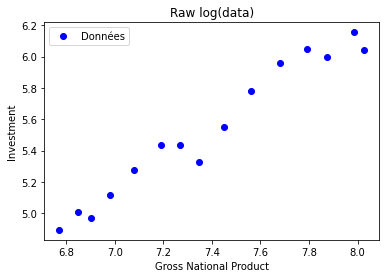

In [141]:
data['gnp_log'] = np.log(data['gnp'])
data['invest_log'] = np.log(data['invest'])

plt.plot(data['gnp_log'], data['invest_log'], 'bo', label='Données')
plt.title("Raw log(data)")
plt.xlabel("Gross National Product")
plt.ylabel("Investment")
plt.legend()
plt.show()


In [142]:
data.head()


,year,gnp,invest,cpi,interest,gnp_log,invest_log
0,1968,873.4,133.3,82.54,5.16,6.772394,4.892602
1,1969,944.0,149.3,86.79,5.87,6.850126,5.005958
2,1970,992.7,144.2,91.45,5.95,6.900429,4.971201
3,1971,1077.6,166.4,96.01,4.88,6.982492,5.114395
4,1972,1185.9,195.0,100.00,4.50,7.078257,5.273000


_NOTE : Lorsque l’on traite des données monétaires, on travaille souvent en échelle logarithmique (pour prendre en compte les différences d’échelle)._


_Les questions suivantes (3 à 6) doivent être réalisées par l’intermédiaire d’opérations élémentaires, sans utiliser de librairies existantes._


### <ins>Question 3 :</ins>

> Pour la régression de ”Investment” (variable à expliquer, output) sur ”GNP” (variable explicative, covariable), estimer l’intercept et la pente, leurs écart-types, ainsi que le coefficient de détermination. Les afficher dans une forme lisible.


On part de la formule : $Z^TZ\hat{\theta}=Z^TY$ avec $\hat{\theta}$ une solution.

On a donc $\hat{\theta} = (Z^TZ)^{-1}Z^TY$


- Intercept et Pente


In [143]:
def get_X(abscissa):
    return np.array(data[abscissa]).reshape(-1, 1)

def get_Z(X):
    if np.ndim(X) == 1:
        X = X.reshape(-1, 1)
    return np.array([[1, x[0]] for x in X])

def get_Y(ordinate):
    return np.array(data[ordinate]).reshape(-1, 1)

def get_thetas(Y, Z):
    return inv(Z.T@Z)@Z.T@Y


In [144]:
X = get_X('gnp_log')
Y = get_Y('invest_log')
Z = get_Z(X)

In [145]:
thetas = get_thetas(Y, Z)
theta_0 = thetas[0][0]
theta_1 = thetas[1][0]

In [146]:
print(f'Intercept de la régression (theta_0): {theta_0:.4f}')
print(f'Pente de la régression (theta_1): {theta_1:.4f}')


Intercept de la régression (theta_0): -1.9636
Pente de la régression (theta_1): 1.0153


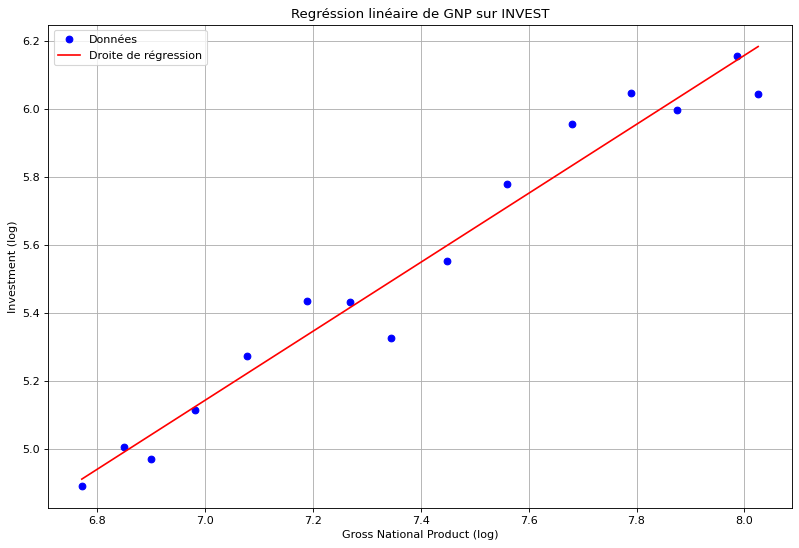

In [147]:
# Equation de la droite de régression
Y_hat = theta_1 * data['gnp_log'] + theta_0

# Mise à l'échelle logarithmique
plt.figure(figsize=(12, 8), dpi=80)
plt.grid()

# Tracé de la droite de régression et des données
plt.plot(data['gnp_log'], data['invest_log'], 'bo', label='Données')
plt.plot(data['gnp_log'], Y_hat, 'r', label='Droite de régression')

# Titre, légende et nom des axes
plt.title("Regréssion linéaire de GNP sur INVEST")
plt.xlabel("Gross National Product (log)")
plt.ylabel("Investment (log)")

plt.legend()
plt.show()


- Ecart-types : $$\sqrt{\frac{1}{n} \sum_{i=1}^n (x_{i} - \bar{x}_{n})^2}$$


In [148]:
def get_standard_residuals(Z, Y, thetas):
    return np.sqrt(((Z@thetas - Y) ** 2).sum() / (X.shape[0] - X.shape[1] - 1))


def get_standard_deviations(Z, Y, thetas):
    return get_standard_residuals(Z, Y, thetas) * np.sqrt(np.diag(inv(Z.T@Z)))

In [149]:
theta_0_standard, theta_1_standard = get_standard_deviations(Z, Y, thetas)

print(f'Ecart-type de l\'intercept: {theta_0_standard:.4f}')
print(f'Ecart-type de la pente: {theta_1_standard:.4f}')


Ecart-type de l'intercept: 0.4095
Ecart-type de la pente: 0.0554


- coefficient de détermination : $$R^2 = \frac{\sum_{i=1}^n{(\hat{Y}_i - \bar{Y})^2}}{\sum_{i=1}^n{(Y_i - \bar{Y})^2}}$$

In [150]:
def get_r2(Z, Y, thetas):
    return ((Z@thetas - Y.mean()) ** 2).sum() / ((Y - Y.mean()) ** 2).sum()

In [151]:
r2 = get_r2(Z, Y, thetas)

print(f'Coefficient de détermination R² : {r2:.4f}')


Coefficient de détermination R² : 0.9628


Nous constatons que le coefficient de détermination est proche de 1, ce qui tend à montrer que les points observés sont rassemblés autour de la droite de régression (un coefficient de 0 montrerait que le nuage de point est dispersé autour de cette droite) : l'estimation est donc plutôt bonne au regard de ce score.

### <ins>Question 4 :</ins>

> La pente estimée précédemment est-elle statistiquement significative ? On fera un test de student (t-test). Donner la valeur de la statistique de test ainsi que la p-valeur.


In [152]:
def get_gramian_matrix(Z):
    return Z.T @ Z / np.shape(Z)[0]


def get_diagonal_inverse(matrix):
    return np.diag(np.linalg.inv(matrix))


def get_degree(Z):
    return Z.shape[0] - Z.shape[1]


def student_test(Z, Y, thetas):
    inversed_gramian_matrix_Z = get_diagonal_inverse(get_gramian_matrix(Z))
    return np.squeeze(np.sqrt(Z.shape[0]) * thetas) / np.sqrt((get_standard_residuals(Z, Y, thetas) ** 2) * inversed_gramian_matrix_Z)


def get_p_value(Z, Y, thetas):
    return 2 * stats.t.sf(student_test(Z, Y, thetas), get_degree(Z))


In [153]:
student_value = student_test(Z, Y, thetas)
p_value = get_p_value(Z, Y, thetas)

print(f'La valeur de student_value pour theta1 est : {student_value[1]:.4f}')
print(f'La valeur de p_value pour theta1 est : {p_value[1]:.4f}')


La valeur de student_value pour theta1 est : 18.3320
La valeur de p_value pour theta1 est : 0.0000


### <ins>Question 5 :</ins>

> Pour GNP égal à 1000, estimer l’investissement prédit par le modèle. Pour GNP égal à 1000, donner l’intervalle de confiance pour la valeur prédite et l’intervalle de confiance pour la variable à expliquer “Investment”, au niveau 90%. On pourra se référer à la section 3.1.3 “Confidence intervals for the predicted values” du polycopié dans laquelle chaque intervalle est défini, $CI(z)$ et $PI(z)$, respectivement (avec les notations du polycopié, $z = (1,1000)^T$ ).


- Investissement prédit par le modèle :

In [154]:
GNP = 1000

prediction = theta_0 + np.log(GNP) * theta_1

print(f"Pour GNP = {GNP}, l'investissement prédit par le modèle est de : {np.exp(prediction):.4f} (en valeur log : {prediction:.4f}).")

Pour GNP = 1000, l'investissement prédit par le modèle est de : 155.9794 (en valeur log : 5.0497).


- Intervale de confiance :

In [155]:
def get_student_percentile(Z, alpha):
    return stats.t.ppf(q = alpha, df = get_degree(Z))

def get_CI_PI(Z, Y, thetas, alpha, z_predicted, interval):
    center = np.squeeze(z_predicted @ thetas)
    percentile = get_student_percentile(Z, (1 - alpha / 2))
    residual_std = get_standard_residuals(Z, Y, thetas)

    middle_length = percentile * residual_std * np.sqrt(np.diag(interval + z_predicted @ (np.linalg.inv(Z.T @ Z)) @ z_predicted.T))
    
    return center - middle_length, center + middle_length

In [156]:
z_predicted = get_Z(np.log(np.array([1000])))

CI_lower, CI_upper = get_CI_PI(Z, Y, thetas, 0.10, z_predicted, 0)
PI_lower, PI_upper = get_CI_PI(Z, Y, thetas, 0.10, z_predicted, 1)

print(f'Les valeurs des bornes de CI sont : {np.exp(CI_lower.squeeze()):.4f} (log : {CI_lower.squeeze():.4f}) et {np.exp(CI_upper.squeeze()):.4f} (log : {CI_upper.squeeze():.4f})')
print(f'Les valeurs des bornes de PI sont : {np.exp(PI_lower.squeeze()):.4f} (log : {PI_lower.squeeze():.4f}) et {np.exp(PI_upper.squeeze()):.4f} (log : {PI_upper.squeeze():.4f})')


Les valeurs des bornes de CI sont : 146.6755 (log : 4.9882) et 165.8735 (log : 5.1112)
Les valeurs des bornes de PI sont : 132.0024 (log : 4.8828) et 184.3117 (log : 5.2166)


### <ins>Question 6 :</ins>

> Sur un graphe avec échelle logarithmique, avec GNP en abscisse et investment en ordonnée, tracer les données, la droite de régression, ainsi que les intervalle CI et PI (pour toutes les valeurs de log(GNP) comprises entre le maximum et le minimum observé sur les données)


In [157]:
def predict_values(Z, theta):
    return Z @ theta

def plot_intervals(Z, Y, thetas):
    # Mise à l'échelle logarithmique
    plt.figure(figsize=(12, 8), dpi=80)
    plt.grid()

    all_CI_lower, all_CI_upper = get_CI_PI(Z, Y, thetas, 0.10, Z, 0)
    all_PI_lower, all_PI_upper = get_CI_PI(Z, Y, thetas, 0.10, Z, 1)

    # Tracé de la droite de régression et des données
    plt.plot(data['gnp_log'], data['invest_log'], 'bo', label='Données')
    plt.plot(data['gnp_log'], Y_hat, 'r', label='Droite de régression')

    plt.plot(Z[:, 1], all_CI_lower, color='orange', label='intervalles CI')
    plt.plot(Z[:, 1], all_CI_upper, color='orange')
    plt.plot(Z[:, 1], all_PI_lower, color='green', label='intervalles PI')
    plt.plot(Z[:, 1], all_PI_upper, color='green')

    # Titre, légende et nom des axes
    plt.title("Regréssion linéaire de GNP sur INVEST - Intervalles au niveau 90%")
    plt.xlabel("Gross National Product (log)")
    plt.ylabel("Investment (log)")

    plt.legend()
    plt.plot()


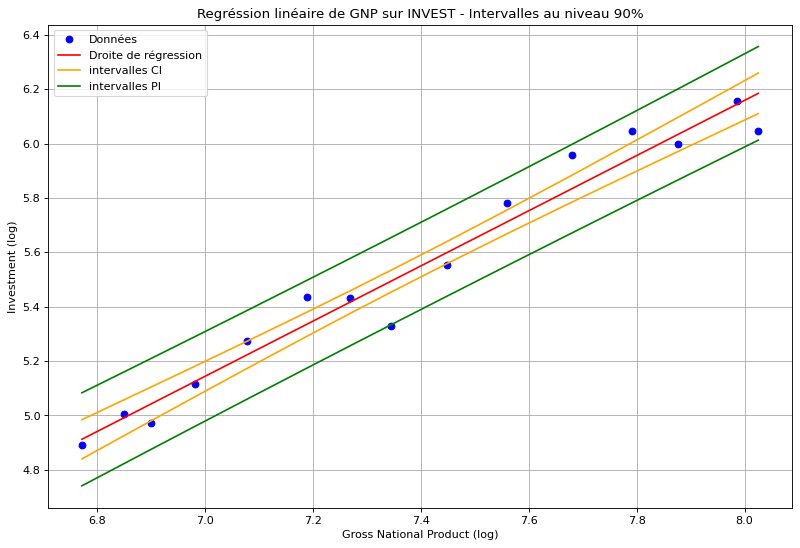

In [158]:
plot_intervals(Z, Y, thetas)

### <ins>Question 7 :</ins>

> En utilisant des classes/librairies existantes, donner l’intercept, la pente, le coefficient de détermination ainsi que l’investissement prédit par le modèle quand GNP vaut 1000. La classe LinearRegression() de sklearn.linear_model est suggérée mais pas obligatoire. Vérifier que les valeurs calculées ici coïncident avec celles des questions précédentes.


In [159]:
# Redefining the variabes
X = data[['gnp_log']]
Y = data['invest_log']

linear_regression = LinearRegression()
linear_regression.fit(X, Y)

theta_0_linear = linear_regression.intercept_
theta_1_linear = linear_regression.coef_[0]

Y_hat_linear = theta_0_linear + theta_1_linear * X

Y_hat_ref = linear_regression.predict(np.log(GNP).reshape(-1, 1))
Y_hat_ref = np.exp(Y_hat_ref[0])

print('Selon Scikit-Learn :')
print(f" - Intercept de la régression : {theta_0_linear:.4f}")
print(f" - Pente de la régression : {theta_1_linear:.4f}")
print(f" - Coefficient de détermination : {r2_score(Y, Y_hat_linear):.4f}")
print(f" - Pour GNP = {GNP}, l'investissement prédit par le modèle est de : {Y_hat_ref:.4f}")


Selon Scikit-Learn :
 - Intercept de la régression : -1.9636
 - Pente de la régression : 1.0153
 - Coefficient de détermination : 0.9628
 - Pour GNP = 1000, l'investissement prédit par le modèle est de : 155.9794


C:\Users\ledez\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### <ins>Question 8 :</ins>

> Sur un graphe avec échelle logarithmique, avec GNP en abscisse et investment en ordonnée, tracer les données, la droite de régression, ainsi que l’investissement prédit par le modèle quand GNP vaut 1000 (on donnera à ce point une couleur différente).


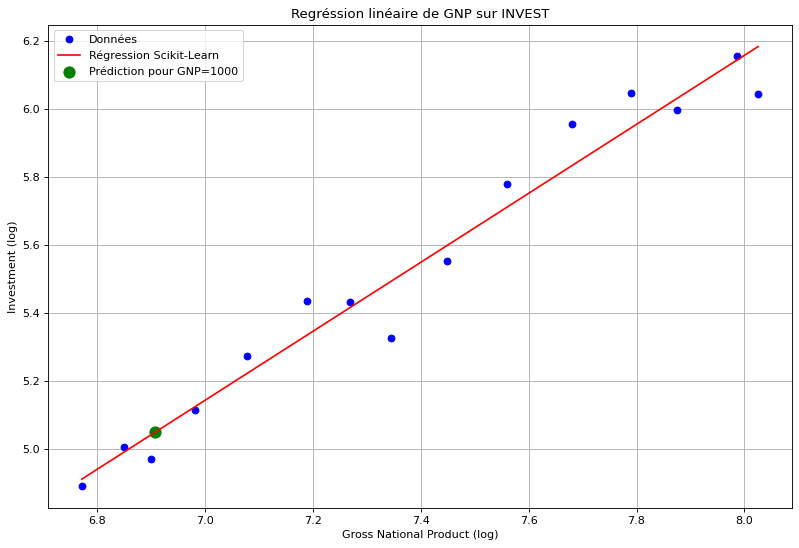

In [160]:
# Génération de l'axe des abscisses
X_min = data.gnp_log.min()
X_max = data.gnp_log.max()
X_abscissa = np.linspace(X_min, X_max, num = 100)

# Equation de la droite de régression
Y_hat = theta_1_linear * X_abscissa + theta_0_linear

# Mise à l'échelle logarithmique
plt.figure(figsize=(12, 8), dpi=80)
plt.grid()

# Tracé de la droite de régression et des données
plt.plot(X, Y, 'bo', label='Données')
plt.plot(X_abscissa, Y_hat, 'r', label='Régression Scikit-Learn')
plt.scatter([np.log(GNP)], [np.log(Y_hat_ref)], color='g',
            label=f'Prédiction pour GNP={GNP}', s=100)

# Titre, légende et nom des axes
plt.title("Regréssion linéaire de GNP sur INVEST")
plt.xlabel("Gross National Product (log)")
plt.ylabel("Investment (log)")

plt.legend()
plt.show()


_NOTE : On introduit une nouvelle variable explicative, la variable interest (sans transformation logarithmique). Les questions suivantes (9 à 12) doivent être réalisées par l’intermédiaire d’opéra- tions élémentaires, sans utiliser de librairies existantes (on utilisera par exemple inv et eig de numpy.linalg)._


### <ins>Question 9 :</ins>

> Pour la régression de Investment sur GNP et Interest, calculer la matrice de Gram non standardisée $Z^TZ$. Est-elle de rang plein ?


In [161]:
# Redefining the variables
X = data[['gnp_log', 'interest']]
Y = data['invest_log']
Z = pd.concat([pd.DataFrame(np.ones(X.shape[0])), X], axis = 1)

Z_gramian = Z.T @ Z

print('Ci-dessous la matrice de Gram :')
print(Z_gramian)


Ci-dessous la matrice de Gram :
                   0     gnp_log    interest
0          15.000000  110.752821  111.790000
gnp_log   110.752821  820.248477  839.188543
interest  111.790000  839.188543  943.855700


In [162]:
print('Les dimensions de la matrice de Gram : ', Z_gramian.shape)
print('Le rang de la matrice de Gram : ', np.linalg.matrix_rank(Z_gramian))

if Z_gramian.shape[1] == np.linalg.matrix_rank(Z_gramian):
    print('La matrice de Gram de Z est donc de rang plein')


Les dimensions de la matrice de Gram :  (3, 3)
Le rang de la matrice de Gram :  3
La matrice de Gram de Z est donc de rang plein


### <ins>Question 10 :</ins>

> Pour la régression de Investment sur GNP et interest, estimer les 3 coefficients et leurs écart-types ainsi que le coefficient de détermination. En plus, faire un test de Student de significativité de chaque coefficient (donner la statistique de test et la p-valeur). Afficher les résultats dans une forme convenable. Discuter de la significativité des coefficients.


- Pour estimer les trois coefficients et leurs écarts-types nous partons de la formule suivante :
$$(Z^TZ)\hat{\theta} = Z^TY$$
donc,
$$\hat{\theta} = (Z^T Z)^{-1} Z^T Y$$

In [168]:
inverse_gram = np.linalg.inv(Z_gramian)
thetas = np.dot(np.dot(inverse_gram, Z.transpose()), Y)

print(f' - Intercept : {thetas[0]:.4f}')
print(f' - Coefficient de régression pour GNP : {thetas[1]:.4f}')
print(f' - Coefficient de régression pour Interest : {thetas[2]:.4f}')


 - Intercept : -2.1805
 - Coefficient de régression pour GNP : 1.0512
 - Coefficient de régression pour Interest : -0.0065


- Pour les calculs des variances nous partons de la formule suivante :
$$
\mathbb{V}(\hat{\beta}_i) = \hat{\sigma}^2 (Z^T Z)^{-1}_{ii} = \frac {\hat{\sigma}^2}{n} (G)^{-1}_{ii}
$$
avec $\hat{\sigma}^2 = \frac{1}{n-3} \|Y - \hat{Y}\|^2$, pour une matrice de Gram de rang 3.

In [164]:
Y_hat_3 = np.dot(Z, thetas)
noise_hat_3 = (1 / (len(X) - 3)) * (np.linalg.norm(Y - Y_hat_3) ** 2)
covariance_thetas = noise_hat_3 * inverse_gram
standard_thetas = np.array([np.sqrt(covariance_thetas[i, i]) for i in range(3)])

print('Variance :')
print(f' - Intercept : {standard_thetas[0]:.4f}')
print(f' - Coefficient de régression pour GNP : {standard_thetas[1]:.4f}')
print(f' - Coefficient de régression pour Interest : {standard_thetas[2]:.4f}')


Variance :
 - Intercept : 0.6624
 - Coefficient de régression pour GNP : 0.1021
 - Coefficient de régression pour Interest : 0.0153


- Calcul du coefficient de détermination :

In [165]:
r2 = 1 - (np.linalg.norm(Y - Y_hat_3) / np.linalg.norm(Y - Y.mean())) ** 2

print(f"Coefficient de détermination : {r2:.4f}")


Coefficient de détermination : 0.9633


- Loi de Student :

In [166]:
statistic_thetas = thetas / standard_thetas

print('Statistiques de test :')
print(f' - Intercept : {statistic_thetas[0]:.4f}')
print(f' - Coefficient de régression pour GNP : {statistic_thetas[1]:.4f}')
print(f' - Coefficient de régression pour Interest : {statistic_thetas[2]:.4f}')


Statistiques de test :
 - Intercept : -3.2918
 - Coefficient de régression pour GNP : 10.3001
 - Coefficient de régression pour Interest : -0.4255


- P-valeurs associées :

In [167]:
p_value_thetas = 2 * (1 - stats.t.cdf(np.abs(statistic_thetas), df = len(X - 3)))

print('P-valeurs :')
print(f' - Intercept : {p_value_thetas[0]:.4f}')
print(f' - Coefficient de régression pour GNP : {p_value_thetas[1]:.4f}')
print(f' - Coefficient de régression pour Interest : {p_value_thetas[2]:.4f}')


P-valeurs :
 - Intercept : 0.0049
 - Coefficient de régression pour GNP : 0.0000
 - Coefficient de régression pour Interest : 0.6765


Grace aux derniers résultats obtenus ci-dessus, nous pouvons déduire les choses suivantes :

- Pour theta_0 et theta_1, il est peu vraisemblalble que nos valeurs soient tombées hasard. Ces deux coefficients sont donc significatifs et à retenir.

- Cependant, pour theta_2, nous avons 67% de chances de retomber sur cette valeur. Dans ce cas là l'hypothèse H0 est à retenir et, le coefficient theta_2 n'est pas significatif

### <ins>Question 11 :</ins>

> Pour les valeurs de GNP 1000 et interest 10, i.e., $z =(1, 1000, 10)^T$ , prédire log(investment) et donner les intervalles de confiance CI(z) et PI(z) au niveau 99.9%.


In [ ]:
Z = (1, np.log(1000), 10)
Y_predicted = np.dot(Z, θ2)
np.exp(Y_predicted)

t = stats.t.ppf([0.0005, 0.9995], len(X) - 3)

z = pd.Series([1, np.log(1000), 10]).T

Z = pd.concat([pd.DataFrame(np.ones(X.shape[0])), X], axis = 1)

a = z.T @ np.linalg.inv(Z.T@Z) @ z


CI_1 = Y_predicted + t[0] * theta_hat * np.sqrt(a)
CI_2 = Y_predicted + t[1] * theta_hat * np.sqrt(a)

PI_1 = Y_predicted + t[0] * theta_hat * np.sqrt(1 + a)
PI_2 = Y_predicted + t[1] * theta_hat * np.sqrt(1 + a)


In [ ]:
print("L'intervalle de confiance de la valeur prédite:")
print("CI = [ {} , {} ] \n".format(np.exp(CI_1), np.exp(CI_2)))
print("L'intervalle de confiance de la variable à expliquer:")
print("PI = [ {} , {} ]".format(np.exp(PI_1), np.exp(PI_2)))


In [ ]:
print("En échelle logarithmique\n")
print("L'intervalle de confiance de la valeur prédite:")
print("CI = [ {} , {} ] \n".format(CI_1, CI_2))
print("L'intervalle de confiance de la variable à expliquer:")
print("PI = [ {} , {} ]".format(PI_1, PI_2))


### <ins>Question 12 :</ins>

> Sur un même graphe à 3 dimensions avec les axes suivants : log(GNP), Interest, and log(Investment), tracer les données, le “plan” de régression et les surfaces correspondantes aux intervalles de confiance à 99.9% (ces surfaces seront tracées sur le domaine de définition des données). On pourra par exemple utiliser la librairie mplot3D


### <ins>Question 13 :</ins>

> En utilisant des classes/librairies existantes, donner les coefficients de régression, le coefficient de détermination ainsi que l’investissement prédit par le modèle quand GNP vaut 1000 et interest 10. La classe LinearRegression() de sklearn.linear_model est suggérée mais pas obligatoire. Vérifier que les valeurs calculées ici coïncident avec celles des questions précédentes.
